# 3. CKY parsing

## Preparation

In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
import nltk

import time
from collections import defaultdict

from dataset import load_sentences, load_grammar
from parser import CkyParser


if False:   # Set this as True if it is your first time use NLTK grammer
    nltk.download("large_grammars")

In [2]:
grammar = load_grammar()
sentences = load_sentences()
parser = CkyParser(grammar)
print("Number of sentences:", len(sentences))
print(grammar)

Number of sentences: 98
Grammar with 16328 productions (start state = SIGMA)
    __DECL_VB__NP_NN__VERB_MD__VERB_VB__NP_PPO__ -> __DECL_VB__NP_NN__VERB_MD__VERB_VB__ NP_PPO
    __NOUN_NP__columbus__saint__ -> columbus saint
    pt_verb_vbg -> 'originating'
    __NOUN_NP__dallas__fort__ -> dallas fort
    RELCL_VBZ -> __RELCL_VBZ__NP_WPS__VERB_VBZ__NP_NN__ NREL_BEZ
    NP_NNS -> __NP_NNS__NP_NN__NOUN_NNS__ PP_NNS
    DECL_VB -> __DECL_VB__VERB_MD__NP_PPSS__VERB_VB__NP_PPO__PP_NNS__PP_NN__ pt_char_per
    NP_NN -> __NP_NN__ADJ_AT__NOUN_NN__ PREP_IN
    NP_NNS -> __NP_NNS__QUANP_ABN__NOUN_NNS__PP_NPS__PP_NP__ pt_char_per
    NP_NN -> __NP_NN__ADJ_DT__NP_NP__ NOUN_NN
    __SUBCL_VB__CONJ_CS__NP_PPSS__ -> CONJ_CS NP_PPSS
    VP_VBG -> __VP_VBG__VERB_VBG__PP_NP__ AVPNP_NP
    __NP_NNS__QUANP_AP__AJP_JJ__ -> QUANP_AP AJP_JJ
    DECL_BER -> __DECL_BER__pt_verb_ber__AVP_RB__NP_NNS__PP_NP__PP_NP__PP_NP__ pt_char_per
    __NOUN_CD__two__hundred__ -> two hundred
    __NOUN_NP__tuesday__the__ -> tu

In [3]:
if True:   # Set it as True to calculate the ground truth counts on the fly.
    nltk_parser = nltk.parse.BottomUpChartParser(grammar)
    gt_counts = [0] * len(sentences)
    for idx, senten in enumerate(sentences):
        try:
            chart = nltk_parser.chart_parse(senten)
        except ValueError:  # The parser will raise an ValueError with unknown words.
            continue
        gt_trees = list(chart.parses(grammar.start()))
        gt_counts[idx] = len(gt_trees)

    if False:   # Set it as True to save the ground truth counts into file.
        with open("../datasets/ground_truth_trees_counts.txt", "w", encoding="utf-8") as file:
            file.write("\n".join(map(str, gt_counts)))
else:
    with open("../datasets/ground_truth_trees_counts.txt", encoding="utf-8") as file:
        gt_counts = list(map(lambda x: int(x.strip()), file.readlines()))
    assert len(gt_counts) == len(sentences)

## Reconiger / Counter

Actually, I didn't design a indepdent recognizer. Instead, I used a counter, because they are same in terms of time complexity. Given a sentence, when the counting result is 0, rejects it as an ungrammatical sentence; otherwise accepts it.

----

Counter design: the core idea is, we record the counting on subtrees. When induce to the parent, the counting of the parent increases with the production of countings of children.

```
Data structure:
    Ch(i,k) eventually contains {A | A ⇒* wi ... wk-1}, initially all empty. 
    Counting(i,j,s) represents the number of parse trees of subsentence [i...j] with nonterminal s, initially all 0.

for each i from 1 to n:
    for each production rule A → w_i:
        add A to Ch(i, i+1)
        Counting(i,i+1,A) = 1

for each width b from 2 to n:
    for each start position i from 1 to n-b+1:
        for each left width k from 1 to b-1:
            for each B in Ch(i,i+k) and C in Ch(i+k,i+b):
                for each production rule A -> B C:
                    add A to Ch(i, i+b)
                    Counting(i,i+b,A) += Counting(i,i+k,B) * Counting(i+k,i+b,C)
```

In [4]:
# Test grammatical sentences
assert 0 < parser.count("i am a flight .".lower().split())
assert 0 < parser.count("i am not a city .".lower().split())

# Test ungrammatical sentences. It's notable that number and some words are unable to be recognized.
assert 0 == parser.count("flight am a i .".lower().split())
assert 0 == parser.count("42".lower().split())
assert 0 == parser.count("tatakai".lower().split())

In [5]:
# Check my parse tree counts against the counts in NLTK, and print my parsing results
result_lines = list()
for senten, gt_cnt in zip(sentences, gt_counts):
    assert parser.count(senten) == gt_cnt
    result_lines.append(f"{' '.join(senten)}\t#{gt_cnt}")
    print(result_lines[-1])
if True:
    with open("parsing_results.txt", "w", encoding="utf-8") as file:
        file.write("\n".join(result_lines))

i need a flight from charlotte to las vegas that makes a stop in saint louis .	#2085
what is the cheapest one way flight from phoenix to san diego that arrives in the morning on thursday june second .	#1380
what is the cheapest one way flight from columbus to indianapolis .	#50
is there a flight from memphis to los angeles .	#18
what aircraft is this .	#0
please show me the flights from chicago to detroit that arrive at six p.m. next tuesday .	#20
what flights are available between chicago and indianapolis next wednesday between eleven a.m. and one p.m .	#0
please book a one way coach fare from chicago to indianapolis on united flight two ninety two next wednesday .	#0
show me flights from chicago to kansas city leaving around seven p.m. thursday .	#1059
show american flights after twelve p.m. from miami to chicago .	#0
does united flight four seven four slash fourteen eighty four serve dinner .	#0
what kind of aircraft is american 's flight fifteen oh one that departs at six fifty nin

## Parser

In [6]:
trees = parser.parse(sentences[0])
print("Number of trees:", len(trees))

Number of trees: 2085


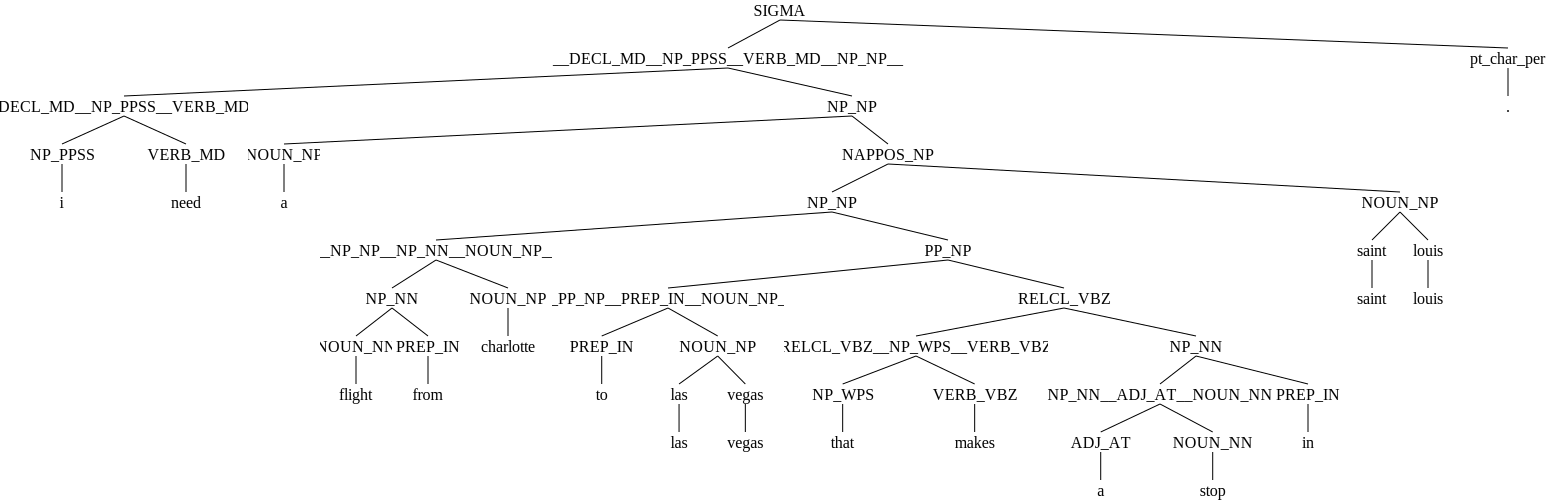

In [7]:
display(trees[0])

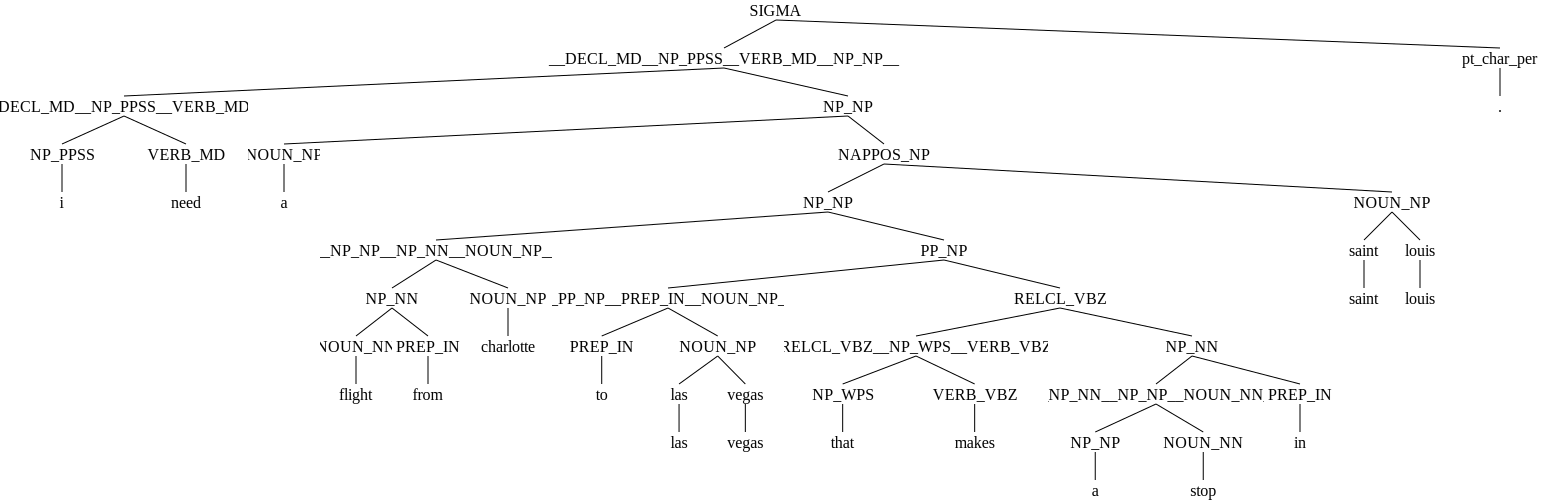

In [8]:
display(trees[1])

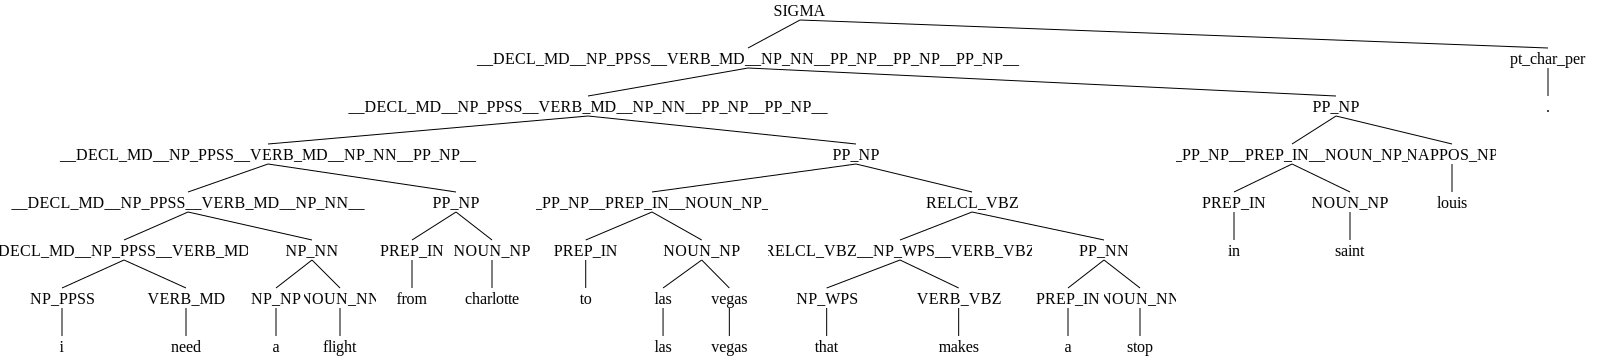

In [9]:
display(trees[-2])

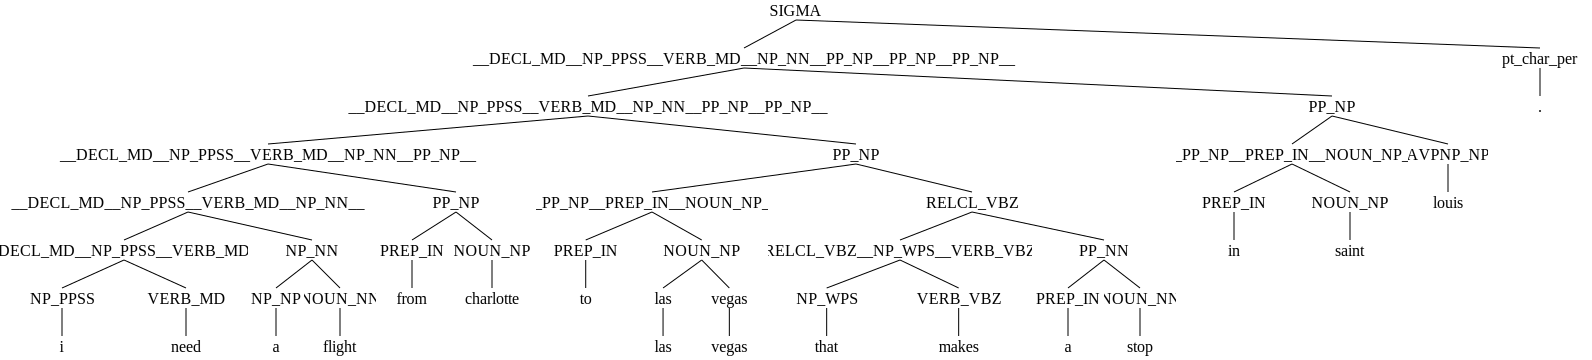

In [10]:
display(trees[-1])

## Sentence Length vs. Time

----

Analysis: We can see that,
- In most cases, $T_{counting} < T_{parsing}$. Because `count()` methods perform CKY algorithm and calculate the number of trees without compute all the parse trees, the time is saved. When the results contain a large number of parse trees, the gaps of time are more distinguishable
- Generally, the longer the sentence, the more computation time is required.

However, the time cost for some data points is unusually high. We can see that these data points are accompanied by a very large number of parse trees ($N_{trees}>10000$). This is caused by the inner loop of CKY algorithm:

```
for each B in Ch(i,i+k) and C in Ch(i+k,i+b):   # The scale increases with the number of trees
    for each production rule A -> B C:          # This is O(1) thanks to hash map (dict)
        add A to Ch(i, i+b)
```

In [11]:
def timer(method, senten: list[str], gt_cnt: int) -> float:
    t = time.time()
    cnt = method(senten)
    t = time.time() - t
    if not isinstance(cnt, int):
        cnt = len(cnt)
    assert cnt == gt_cnt
    return t * 1000

sentence_counts = defaultdict[int, int](lambda: 0)
trees_counts = defaultdict[int, int](lambda: 0)
counting_times = defaultdict[int, float](lambda: 0.0)
parsing_times = defaultdict[int, float](lambda: 0.0)
for senten, gt_cnt in zip(sentences, gt_counts):
    length = len(senten)
    sentence_counts[length] += 1
    trees_counts[length] += gt_cnt
    counting_times[length] += timer(parser.count, senten, gt_cnt)
    parsing_times[length] += timer(parser.parse, senten, gt_cnt)

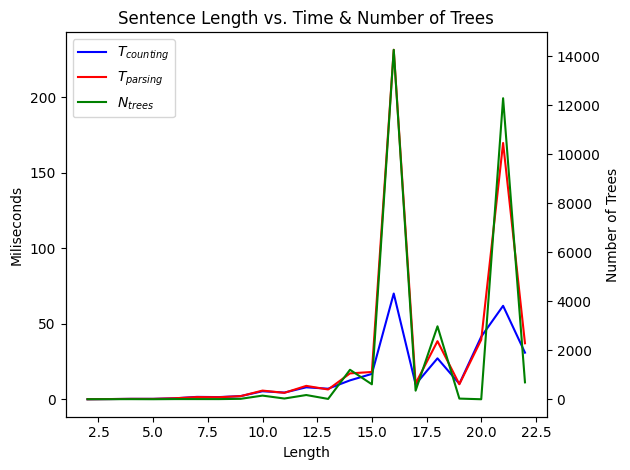

In [12]:
length = sorted(sentence_counts.keys())
ms_counting = [counting_times[k] / sentence_counts[k] for k in length]
ms_parsing = [parsing_times[k] / sentence_counts[k] for k in length]
num_trees = [trees_counts[k] / sentence_counts[k] for k in length]

line_a, = plt.plot(length, ms_counting, label="$T_{counting}$", c="b")
line_b, = plt.plot(length, ms_parsing, label="$T_{parsing}$", c="r")
plt.xlabel("Length") ; plt.ylabel("Miliseconds")

plt.twinx() ; plt.ylabel("Number of Trees")
line_c, = plt.plot(length, num_trees, label="$N_{trees}$", c="g")
plt.legend([line_a, line_b, line_c], [line_a.get_label(), line_b.get_label(), line_c.get_label()], loc="upper left")

plt.title("Sentence Length vs. Time & Number of Trees")
plt.tight_layout()
plt.show()